##$$ \textrm{Linear Regression} $$

##1. 패키지 장착

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots

In [7]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from statsmodels.stats.anova import anova_lm

In [8]:
# !pip install --upgrade pandas
from ISLP import load_data

## 2. 단순선형회귀분석
  - Boston data 불러오기


In [9]:
from ISLP.models import (ModelSpec as MS, summarize , poly)
from pandas.io.formats.format import DataFrameFormatter
# Inside the pandas/io/formats/html.py file (you'll need to find this file in your pandas installation),
# locate the _get_columns_formatted_values function and modify it as follows:
def _get_columns_formatted_values(self) -> list[str]:
        # only reached with non-Multi Index
        # return self.columns._format_flat(include_name=False)  # Replace this line
  formatter = DataFrameFormatter(self.columns, include_name=False)  # With this line
  return formatter._format_col_name_split()

Boston = load_data("Boston")
Boston.columns
X = pd.DataFrame({'intercept': np.ones(Boston.shape[0]), 'lstat': Boston['lstat']})
# 절편을 포함시키는 데이터프레임 생성
print(X[:4])
y = Boston['medv']

   intercept  lstat
0        1.0   4.98
1        1.0   9.14
2        1.0   4.03
3        1.0   2.94


  - Boston data 단순선형회귀분석

In [10]:
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())
# medv ~ lstat
# (adj.) R square / DF (1/504) / Durbin-Watson (auto-cor.)

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     601.6
Date:                Tue, 24 Sep 2024   Prob (F-statistic):           5.08e-88
Time:                        01:17:15   Log-Likelihood:                -1641.5
No. Observations:                 506   AIC:                             3287.
Df Residuals:                     504   BIC:                             3295.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     34.5538      0.563     61.415      0.0

여기서 중요한건 X에 절편이 포함되어야 한다 이때 MS라는 패키지가 절편을 자동 생성한다.
추정량 34.5랑 -0.95
pvalue가 0.05보다 작다 즉 

In [11]:
# MS 구문을 이용해서 입력 행렬 처리
#--------------------------
design = MS(['lstat'])
design = design.fit(Boston)
X = design.transform(Boston)
print(X[:4])
model = sm.OLS(y, X)
results = model.fit()
print(results.params)

   intercept  lstat
0        1.0   4.98
1        1.0   9.14
2        1.0   4.03
3        1.0   2.94
intercept    34.553841
lstat        -0.950049
dtype: float64


MS 구문을 쓰면 자동으로 정면?을 만들어준다.
transform이 절편 만들어 준거


In [12]:
# 새로운 입력변수에 대한 예측 (평균, 신뢰구간, 예측구간)
# -----------------------------------------
new_df = pd.DataFrame({'lstat':[5, 10, 15]})
newX = design.transform(new_df)
print(newX)
new_predictions = results.get_prediction(newX);
print(new_predictions.predicted_mean)
print(new_predictions.conf_int(alpha=0.05))
print(new_predictions.conf_int(obs=True, alpha=0.05))

   intercept  lstat
0        1.0      5
1        1.0     10
2        1.0     15
[29.80359411 25.05334734 20.30310057]
[[29.00741194 30.59977628]
 [24.47413202 25.63256267]
 [19.73158815 20.87461299]]
[[17.56567478 42.04151344]
 [12.82762635 37.27906833]
 [ 8.0777421  32.52845905]]


29.00741194 30.59977628]prediction인터벌 17.56567478 42.04151344컨피던스 인터벌

/tmp/ipykernel_23774/2837087302.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results.params[0],
/tmp/ipykernel_23774/2837087302.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results.params[1], 'r--', linewidth=3)


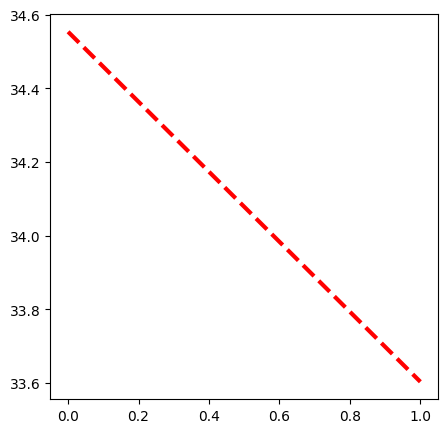

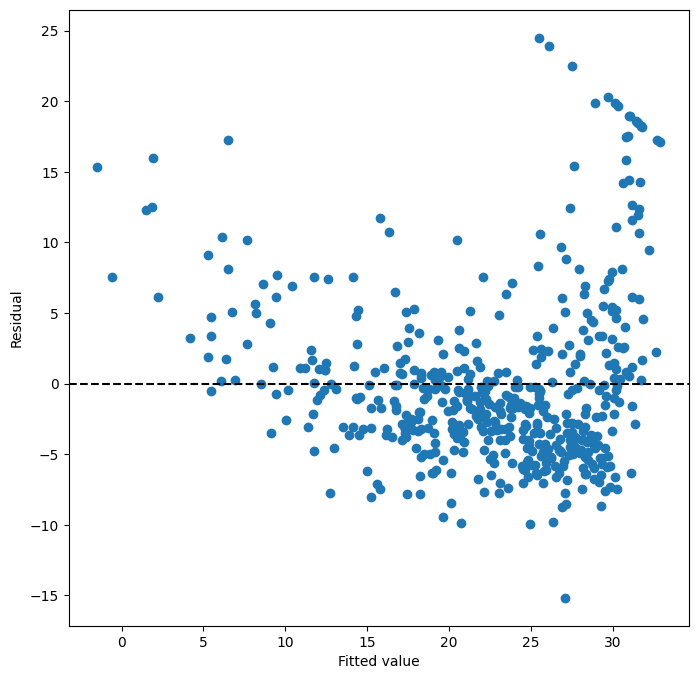

In [13]:
# 평균직선에 대한 그래프 / 잔차에 대한 그래프
# ---------------------------------

import matplotlib.pyplot as plt

def abline(ax, b, m):
  xlim = ax.get_xlim()
  ylim = [m * xlim[0] + b, m * xlim[1] + b]
  ax.plot(xlim, ylim)

def abline(ax, b, m, *args, **kwargs):
  xlim = ax.get_xlim()
  ylim = [m * xlim[0] + b, m * xlim[1] + b]
  ax.plot(xlim, ylim, *args, **kwargs)

ax = subplots(figsize=(5,5))[1]
abline(ax,
results.params[0],
results.params[1], 'r--', linewidth=3)

ax = subplots(figsize=(8,8))[1]
ax.scatter(results.fittedvalues, results.resid)
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
ax.axhline(0, c='k', ls='--');

374

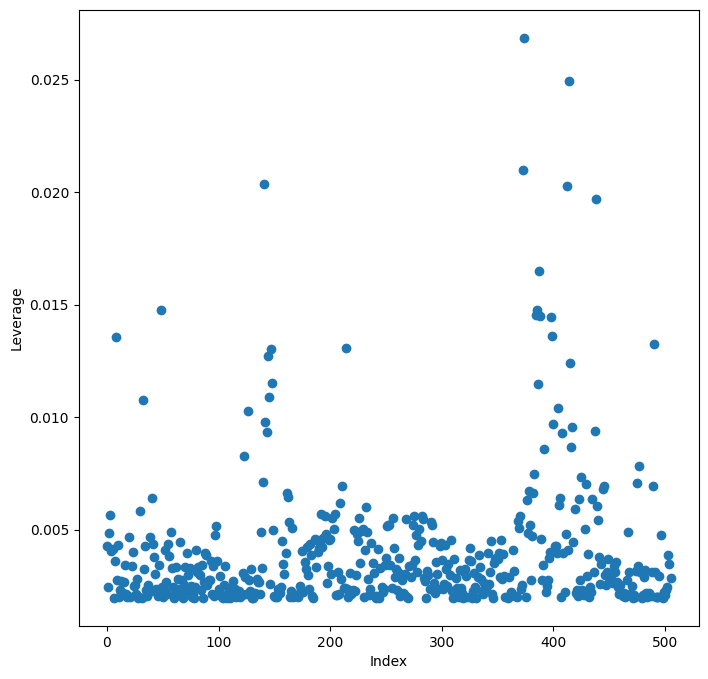

In [14]:
# 관측치에 대한 leverage 계산 및 그래프화
# --------------------------------
infl = results.get_influence()
ax = subplots(figsize=(8,8))[1]
ax.scatter(np.arange(X.shape[0]), infl.hat_matrix_diag)
ax.set_xlabel('Index')
ax.set_ylabel('Leverage')
np.argmax(infl.hat_matrix_diag)


- Boston data 다중선형 회귀분석



In [15]:
# 입력변수를 lstat, age로 확장
# -----------------------

X = MS(['lstat', 'age']).fit_transform(Boston)
model1 = sm.OLS(y, X)
results1 = model1.fit()
print(summarize(results1))

              coef  std err       t  P>|t|
intercept  33.2228    0.731  45.458  0.000
lstat      -1.0321    0.048 -21.416  0.000
age         0.0345    0.012   2.826  0.005


In [16]:
# 입력변수를 mdev를 제외한 모든 변수로 학장
# --------------------------------
terms = Boston.columns.drop('medv')
terms
X = MS(terms).fit_transform(Boston)
model = sm.OLS(y, X)
results = model.fit()
print(summarize(results))

              coef  std err       t  P>|t|
intercept  41.6173    4.936   8.431  0.000
crim       -0.1214    0.033  -3.678  0.000
zn          0.0470    0.014   3.384  0.001
indus       0.0135    0.062   0.217  0.829
chas        2.8400    0.870   3.264  0.001
nox       -18.7580    3.851  -4.870  0.000
rm          3.6581    0.420   8.705  0.000
age         0.0036    0.013   0.271  0.787
dis        -1.4908    0.202  -7.394  0.000
rad         0.2894    0.067   4.325  0.000
tax        -0.0127    0.004  -3.337  0.001
ptratio    -0.9375    0.132  -7.091  0.000
lstat      -0.5520    0.051 -10.897  0.000


pvalue가 높게 나온거는 

유의성검증에서는 유의하다고 나왔을 것이다. 하나라도 0이 아닌게 있기때문
그래서 pvalue가 높은거를 빼고 다시 fit한다. 아주 정확한 예측이 안될수있으니 다른방법도 사용해야한다.
indus       0.0135    0.062   0.217  0.829랑 age         0.0036    0.013   0.271  0.787를 지웠다
계수가 b1...bn 까지 있다.
0.8 0.1 ... 0.9의 값이다. 
pvalue 귀무가설이 맞다고 해서 확률이 낮아서 기각을 한다.

추가로 차원의 저주라고 차원이 커지게 되면 발생하는 문제도 있다.

In [17]:
# 위의 변수 중 age를 제외한 결과 (앞의 표에서 age이 p.vlaue가 높음에 유의)
minus_age = Boston.columns.drop(['medv', 'age'])
Xma = MS(minus_age).fit_transform(Boston)
model1 = sm.OLS(y, Xma)
print(summarize(model1.fit()))

              coef  std err       t  P>|t|
intercept  41.5251    4.920   8.441  0.000
crim       -0.1214    0.033  -3.683  0.000
zn          0.0465    0.014   3.379  0.001
indus       0.0135    0.062   0.217  0.829
chas        2.8528    0.868   3.287  0.001
nox       -18.4851    3.714  -4.978  0.000
rm          3.6811    0.411   8.951  0.000
dis        -1.5068    0.193  -7.825  0.000
rad         0.2879    0.067   4.322  0.000
tax        -0.0127    0.004  -3.333  0.001
ptratio    -0.9346    0.132  -7.099  0.000
lstat      -0.5474    0.048 -11.483  0.000


In [18]:
# 다중공선성을 확인하기 위한 VIF 값을 보여줌
# --------------------------------
vals = [VIF(X, i) for i in range(1, X.shape[1])]
vif = pd.DataFrame({'vif':vals},index=X.columns[1:])
print(vif)

              vif
crim     1.767486
zn       2.298459
indus    3.987181
chas     1.071168
nox      4.369093
rm       1.912532
age      3.088232
dis      3.954037
rad      7.445301
tax      9.002158
ptratio  1.797060
lstat    2.870777


tax를 지워버리는 것도 방법이다.

- 교호작용을 포함한 선형회귀분석
   - 교호작용이라는 두 변수 간의 시너지가 존재하는 경우, 즉 특정 변수가 다른 변수의 영향력에 영향을 줌

In [19]:
# lstat과 age간의 교호작용을 고려
# -------------------------
X = MS(['lstat', 'age', ('lstat', 'age')]).fit_transform(Boston)
model2 = sm.OLS(y, X)
print(summarize(model2.fit()))
# 결과 lstat이 평균을 높여주는 효과가 age가 클수록 커짐

# lstat에 대해서 다항식 차원을 2차까지 늘림
# --------------------------------
X = MS([poly('lstat', degree=2), 'age']).fit_transform(Boston)
model3 = sm.OLS(y, X)
results3 = model3.fit()
print(summarize(results3))
# 2차식까지 통계적 유의성 확인됨

print(anova_lm(results1, results3))
# results1은 lstat에 대한 선형, results3은 lstat에 대한 2차 다항식
# 검정은 다항식을 2차로 쓰는 것이 유의한 지를 검정

              coef  std err       t  P>|t|
intercept  36.0885    1.470  24.553  0.000
lstat      -1.3921    0.167  -8.313  0.000
age        -0.0007    0.020  -0.036  0.971
lstat:age   0.0042    0.002   2.244  0.025
                              coef  std err       t  P>|t|
intercept                  17.7151    0.781  22.681    0.0
poly(lstat, degree=2)[0] -179.2279    6.733 -26.620    0.0
poly(lstat, degree=2)[1]   72.9908    5.482  13.315    0.0
age                         0.0703    0.011   6.471    0.0
   df_resid           ssr  df_diff      ss_diff           F        Pr(>F)
0     503.0  19168.128609      0.0          NaN         NaN           NaN
1     502.0  14165.613251      1.0  5002.515357  177.278785  7.468491e-35


예측의 관점에서 교호작용을 고려 할 필요없ㄷ

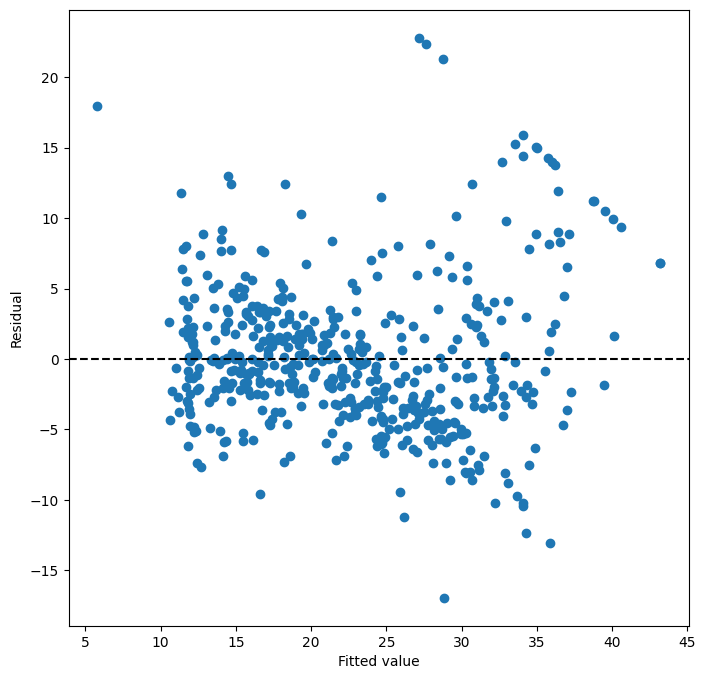

In [20]:
# results3의 결과에 대해서 잔차의 산점도를 그려봄

ax = subplots(figsize=(8,8))[1]
ax.scatter(results3.fittedvalues, results3.resid)
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
ax.axhline(0, c='k', ls='--')

-------------------------------------------




3번째 모형으로 그려본 그림이다.
등분산성 확보되었다. 

- Carseats data 불러오기

In [21]:
# 변수를 불러와서 Sales를 반응변수로 나머지 전체와
# Income*Advertising과 Price*Age의 교호작용을 고려
# --------------------------------------------

Carseats = load_data('Carseats')
print(Carseats.columns)
print(Carseats.head())
allvars = list(Carseats.columns.drop('Sales'))
y = Carseats['Sales']

final = allvars + [('Income', 'Advertising'),('Price', 'Age')]
X = MS(final).fit_transform(Carseats)
model = sm.OLS(y, X)
print(model.fit().aic)
print(summarize(model.fit()))
# 교호작용 중 Income*Advertising만 통계적으로 유의함

Index(['Sales', 'CompPrice', 'Income', 'Advertising', 'Population', 'Price',
       'ShelveLoc', 'Age', 'Education', 'Urban', 'US'],
      dtype='object')
   Sales  CompPrice  Income  Advertising  Population  Price ShelveLoc  Age  \
0   9.50        138      73           11         276    120       Bad   42   
1  11.22        111      48           16         260     83      Good   65   
2  10.06        113      35           10         269     80    Medium   59   
3   7.40        117     100            4         466     97    Medium   55   
4   4.15        141      64            3         340    128       Bad   38   

   Education Urban   US  
0         17   Yes  Yes  
1         10   Yes  Yes  
2         12   Yes  Yes  
3         14   Yes  Yes  
4         13   Yes   No  
1157.337779308029
                      coef  std err       t  P>|t|
intercept           6.5756    1.009   6.519  0.000
CompPrice           0.0929    0.004  22.567  0.000
Income              0.0109    0.003   4.183  0.00

## 3. 가변수 사용법


In [22]:
from ISLP.models import contrast

# data loading
# ------------
Bike = load_data('Bikeshare')
Bike.shape, Bike.columns

((8645, 15),
 Index(['season', 'mnth', 'day', 'hr', 'holiday', 'weekday', 'workingday',
        'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual',
        'registered', 'bikers'],
       dtype='object'))

In [23]:
from ISLP.models import contrast

# data loading
# ------------
Bike = load_data('Bikeshare')
Bike.shape, Bike.columns

((8645, 15),
 Index(['season', 'mnth', 'day', 'hr', 'holiday', 'weekday', 'workingday',
        'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual',
        'registered', 'bikers'],
       dtype='object'))

In [24]:
X2 = MS(['mnth', 'hr', 'workingday','temp', 'weathersit']).fit_transform(Bike)
Y = Bike['bikers']
M1_lm = sm.OLS(Y, X2).fit()
S2 = summarize(M1_lm)
print(S2)

                                 coef  std err       t  P>|t|
intercept                    -68.6317    5.307 -12.932  0.000
mnth[Feb]                      6.8452    4.287   1.597  0.110
mnth[March]                   16.5514    4.301   3.848  0.000
mnth[April]                   41.4249    4.972   8.331  0.000
mnth[May]                     72.5571    5.641  12.862  0.000
mnth[June]                    67.8187    6.544  10.364  0.000
mnth[July]                    45.3245    7.081   6.401  0.000
mnth[Aug]                     53.2430    6.640   8.019  0.000
mnth[Sept]                    66.6783    5.925  11.254  0.000
mnth[Oct]                     75.8343    4.950  15.319  0.000
mnth[Nov]                     60.3100    4.610  13.083  0.000
mnth[Dec]                     46.4577    4.271  10.878  0.000
hr[1]                        -14.5793    5.699  -2.558  0.011
hr[2]                        -21.5791    5.733  -3.764  0.000
hr[3]                        -31.1408    5.778  -5.389  0.000
hr[4]   

intercept에 1월하고 24시가 포함되어있다.

In [25]:
hr_encode = contrast('hr', 'sum')     # 합에 대한 제약을 검
mnth_encode = contrast('mnth', 'sum') # 합에 대한 제약을 검
X2 = MS([mnth_encode, hr_encode, 'workingday','temp', 'weathersit']).fit_transform(Bike)
Y = Bike['bikers']
M2_lm = sm.OLS(Y, X2).fit()
S2 = summarize(M2_lm)
print(S2)
# 마지막 범주의 계수는 나머지 계수들의 합에 음수를 취함
np.sum((M1_lm.fittedvalues - M2_lm.fittedvalues)**2)
# 거의 차이가 없음

                                 coef  std err       t  P>|t|
intercept                     73.5974    5.132  14.340  0.000
mnth[Jan]                    -46.0871    4.085 -11.281  0.000
mnth[Feb]                    -39.2419    3.539 -11.088  0.000
mnth[March]                  -29.5357    3.155  -9.361  0.000
mnth[April]                   -4.6622    2.741  -1.701  0.089
mnth[May]                     26.4700    2.851   9.285  0.000
mnth[June]                    21.7317    3.465   6.272  0.000
mnth[July]                    -0.7626    3.908  -0.195  0.845
mnth[Aug]                      7.1560    3.535   2.024  0.043
mnth[Sept]                    20.5912    3.046   6.761  0.000
mnth[Oct]                     29.7472    2.700  11.019  0.000
mnth[Nov]                     14.2229    2.860   4.972  0.000
hr[0]                        -96.1420    3.955 -24.307  0.000
hr[1]                       -110.7213    3.966 -27.916  0.000
hr[2]                       -117.7212    4.016 -29.310  0.000
hr[3]   

1.481150636351971e-20

mnth[Jan]                    -46.0871    4.085 -11.281  0.000
mnth[Feb]                    -39.2419    3.539 -11.088  0.000
mnth[March]                  -29.5357    3.155  -9.361  0.000
mnth[April]                   -4.6622    2.741  -1.701  0.089
mnth[May]                     26.4700    2.851   9.285  0.000
mnth[June]                    21.7317    3.465   6.272  0.000
mnth[July]                    -0.7626    3.908  -0.195  0.845
mnth[Aug]                      7.1560    3.535   2.024  0.043
mnth[Sept]                    20.5912    3.046   6.761  0.000
mnth[Oct]                     29.7472    2.700  11.019  0.000
mnth[Nov]                     14.2229    2.860   4.972  0.000를 다 더해서 1을 빼면 12월을 구할 수 잇따.

In [26]:
coef_month = S2[S2.index.str.contains('mnth')]['coef']
print(coef_month)
# 제약조건이 걸린 계수 확인
months = Bike['mnth'].dtype.categories
coef_month = pd.concat([coef_month, pd.Series([-coef_month.sum()], index=['mnth[Dec]'])
])
print(coef_month)
# 위 계수의 합에 음수를 취해 마지막 계수를 생성

mnth[Jan]     -46.0871
mnth[Feb]     -39.2419
mnth[March]   -29.5357
mnth[April]    -4.6622
mnth[May]      26.4700
mnth[June]     21.7317
mnth[July]     -0.7626
mnth[Aug]       7.1560
mnth[Sept]     20.5912
mnth[Oct]      29.7472
mnth[Nov]      14.2229
Name: coef, dtype: float64
mnth[Jan]     -46.0871
mnth[Feb]     -39.2419
mnth[March]   -29.5357
mnth[April]    -4.6622
mnth[May]      26.4700
mnth[June]     21.7317
mnth[July]     -0.7626
mnth[Aug]       7.1560
mnth[Sept]     20.5912
mnth[Oct]      29.7472
mnth[Nov]      14.2229
mnth[Dec]       0.3705
dtype: float64


- 월에 대응되는 계수둘을 선도표로 연결해서 시각화함

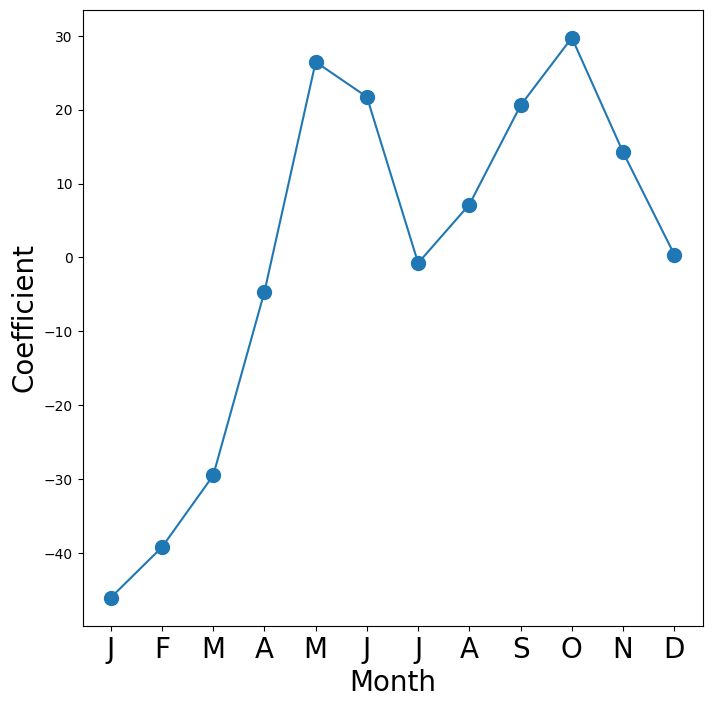

In [27]:
fig_month , ax_month = subplots(figsize=(8,8))
x_month = np.arange(coef_month.shape[0])
ax_month.plot(x_month , coef_month , marker='o', ms=10)
ax_month.set_xticks(x_month)
ax_month.set_xticklabels([l[5] for l in coef_month.index], fontsize
=20)
ax_month.set_xlabel('Month', fontsize=20)
ax_month.set_ylabel('Coefficient', fontsize=20);

다 더하면 0이나온다.

- 시간에 대응되는 계수둘을 선도표로 연결해서 시각화함

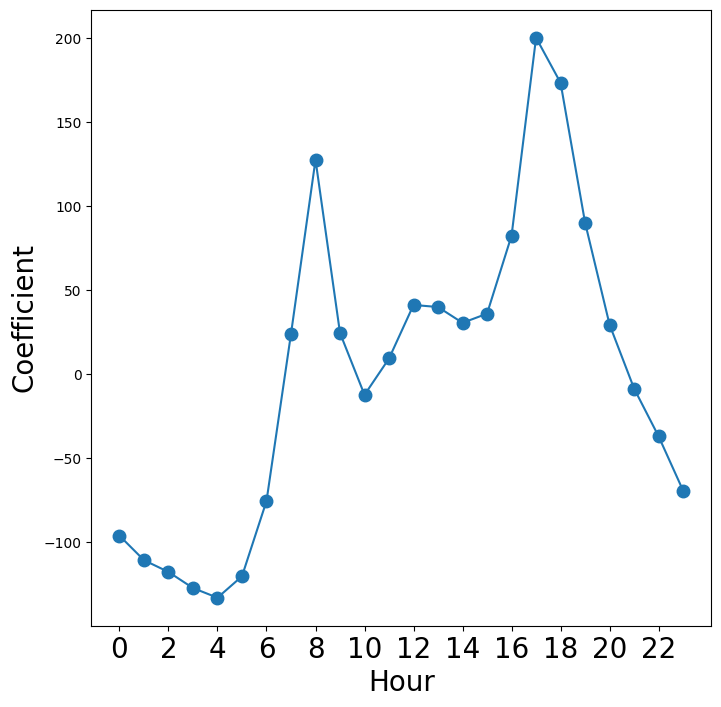

In [28]:
coef_hr = S2[S2.index.str.contains('hr')]['coef']
coef_hr = coef_hr.reindex(['hr[{0}]'.format(h) for h in range(23)])
coef_hr = pd.concat([coef_hr, pd.Series([-coef_hr.sum()], index=['hr[23]'])
])
fig_hr , ax_hr = subplots(figsize=(8,8))
x_hr = np.arange(coef_hr.shape[0])
ax_hr.plot(x_hr , coef_hr , marker='o', ms=9)
ax_hr.set_xticks(x_hr[::2])
ax_hr.set_xticklabels(range(24)[::2], fontsize =20)
ax_hr.set_xlabel('Hour', fontsize=20)
ax_hr.set_ylabel('Coefficient', fontsize=20);

RSS를 그대로 쓰기에는 문제가 있다. f햇(x)과 입실론은 독립이다.

9월24일 찍은 사진 식으로 검증을 하자는 거 같다. 이건 훈련데이터셋을 가져온다.
여기서 시작해서 크로스엔트로피 까지
vallosspy? 


mallows